In [5]:
import warnings
import itertools
import numpy
import matplotlib
import matplotlib.pyplot as pyplot
import pandas
import statsmodels.api as statsmodels_api
import pylab

In [26]:
warnings.filterwarnings("ignore")
pyplot.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [13]:
imacec_df = pandas.read_excel("input.xls", skiprows=[0,1], index_col="Periodo")

In [19]:
imacec_df.columns = ["imacec", "imacec_minero", "imacec_no_minero", "imacec_costo_factores"]

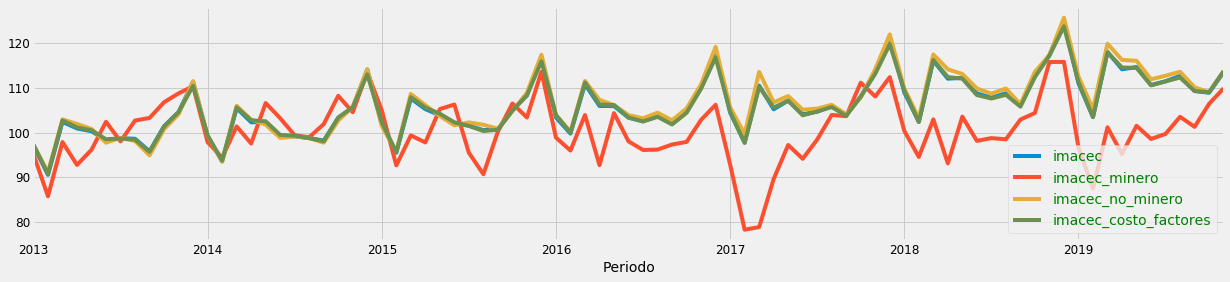

In [20]:
imacec_df.plot(figsize=(19,4))
pyplot.show()

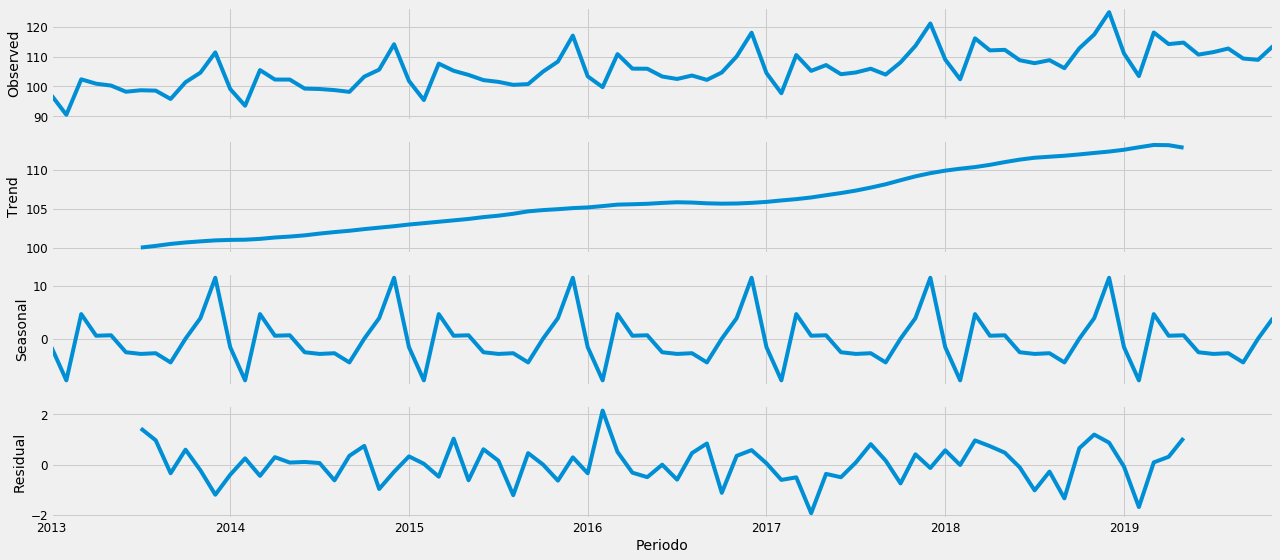

In [23]:
pylab.rcParams['figure.figsize'] = 18,8
decomposition = statsmodels_api.tsa.seasonal_decompose(imacec_df.imacec, model='additive')
fig = decomposition.plot()
pyplot.show()

In [24]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [28]:
sarimax_tuple_array = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = statsmodels_api.tsa.statespace.SARIMAX(imacec_df.imacec,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            sarimax_tuple_array.append((param,param_seasonal,results.aic))
        except: 
            continue

In [33]:
# best fit parameter
sorted(sarimax_tuple_array, key = lambda x : x[2])[0:5]

[((0, 1, 1), (0, 1, 1, 12), 202.56182017775404),
 ((1, 1, 1), (0, 1, 1, 12), 203.40150754454686),
 ((0, 1, 1), (1, 1, 1, 12), 204.8236443862059),
 ((1, 0, 1), (0, 1, 1, 12), 205.58915380074077),
 ((1, 1, 1), (1, 1, 1, 12), 205.87614789294545)]

In [35]:
mod = statsmodels_api.tsa.statespace.SARIMAX(imacec_df.imacec,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3391      0.128     -2.650      0.008      -0.590      -0.088
ar.S.L12      -0.2225      0.259     -0.858      0.391      -0.731       0.286
ma.S.L12      -0.4761      0.317     -1.502      0.133      -1.097       0.145
sigma2         1.8758      0.359      5.225      0.000       1.172       2.579


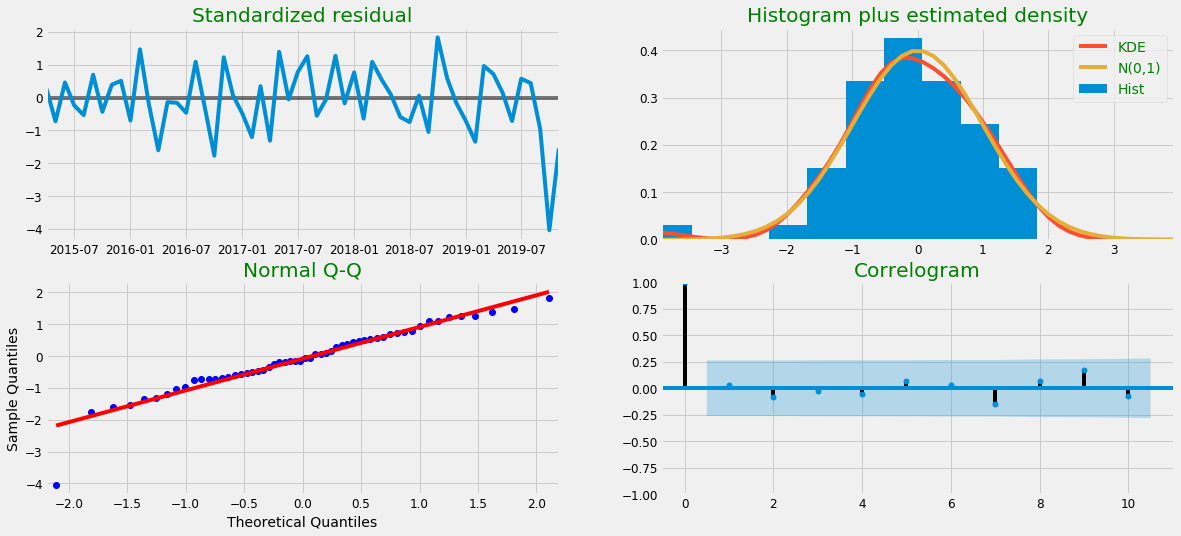

In [41]:
results.plot_diagnostics(figsize=(18, 8))
pyplot.show()

In [42]:
imacec_df.imacec.index.min()

Timestamp('2013-01-01 00:00:00')

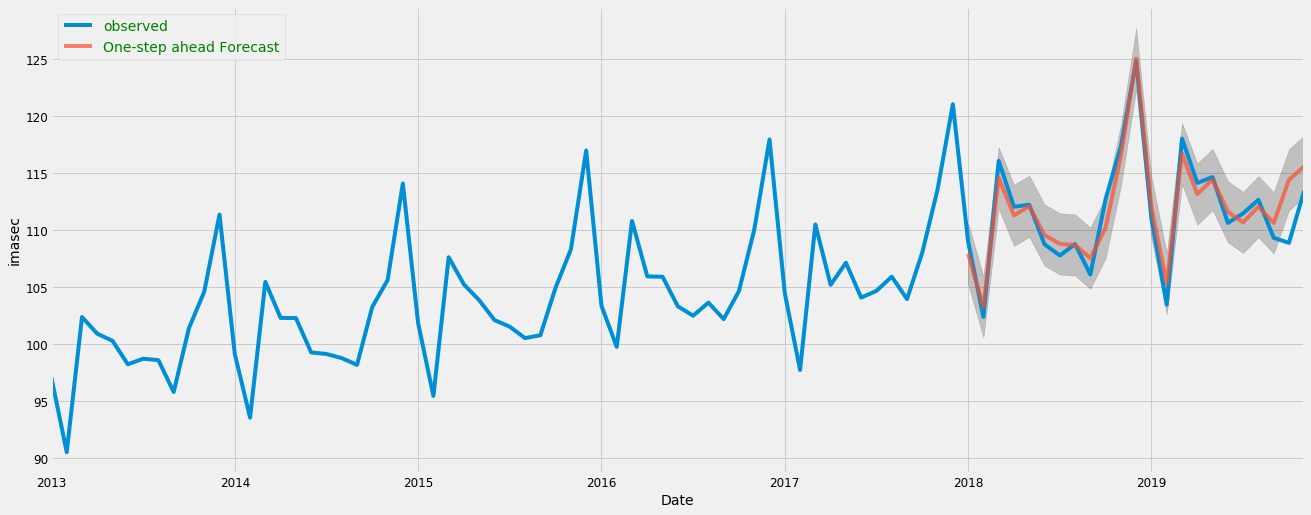

In [49]:
pred = results.get_prediction(start=pandas.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = imacec_df.imacec['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('imasec')
pyplot.legend()
pyplot.show()

In [51]:
y_forecasted = pred.predicted_mean
y_truth = imacec_df.imacec['2018-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(numpy.sqrt(mse), 2)))

The Mean Squared Error is 2.67
The Root Mean Squared Error is 1.63


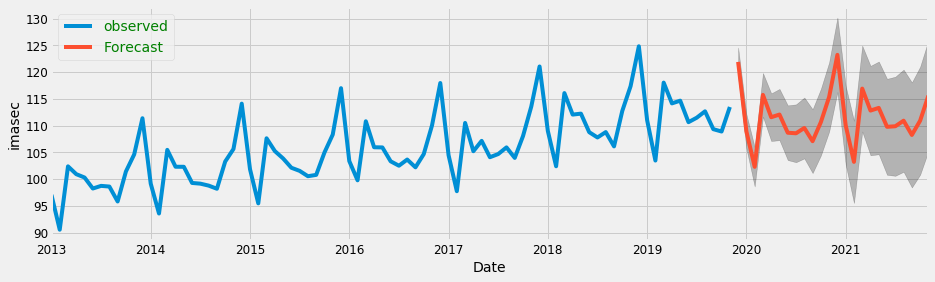

In [54]:
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = imacec_df.imacec.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('imasec')
pyplot.legend()
pyplot.show()